# Предсказание оттока клиентов в банке

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

У итоговой модели F1-мера должна быть не ниже 0.59.

## Содержание<a name="Содержание"></a>

1. [Знакомство с данными](#1.-Знакомство-с-данными)
2. [Подготовка данных](#2.-Подготовка-данных)
	3. [Обработка пропусков](#Обработка-пропусков)
	4. [Прямое кодирование](#Прямое-кодирование)
	5. [Разбиение данных на выборки](#Разбиение-данных-на-выборки)
	6. [Масштабирование признаков](#Масштабирование-признаков)
3. [Исследование задачи](#3.-Исследование-задачи)
	1. [Исследование баланса классов](#Исследование-баланса-классов)
	2. [Таблица исследования](#Таблица-исследования)
	3. [Функции, используемые в исследовании](#Функции,-используемые-в-исследовании)
4. [Несбалансированные классы](#4.-Несбалансированные-классы)
	1. [Подготовка данных для GridSearch](#Подготовка-данных-для-GridSearch)
	2. [Дерево решений](#Дерево-решений-дисбаланс)
	3. [Случайный лес](#Случайный-лес)
	4. [Логистическая регрессия](#Логистическая-регрессия)
	5. [Вывод](#Вывод)
5. [Борьба с дисбалансом](#5.-Борьба-с-дисбалансом)
	1. [Upsampling](#Upsampling)
	2. [Уравновешивание классов](#Уравновешивание-классов)
	3. [Изменение порога классификации](#Изменение-порога-классификации)
	4. [Сравнение способов борьбы с дисбалансом](#Сравнение-способов-борьбы-с-дисбалансом)
6. [Тестирование лучшей модели](#6.-Тестирование-лучшей-модели)

## 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [2]:
sns.set_style('darkgrid')
pd.set_option('mode.chained_assignment', None)

In [3]:
SEED = 42

## 1. Знакомство с данными<a name="1.-Знакомство-с-данными"></a>

Сохраним датасет в переменную `df` и посмотрим на первые 10 строчек.

In [4]:
df = pd.read_csv('Churn.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Каждый объект в наборе данных — это информация о поведении одного пользователя. Известно:

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата
* Exited — факт ухода клиента

Exited — целевой признак.

Также посмотрим на общую информацию о датасете.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Что мы обнаружили:
1. `RowNumber`, `CustomerID` и `Surname` — незначимые переменные, от которых целевой признак не зависит. Избавимся от них.
2. В таблице есть два категориальных признака, которые надо перевести в численные: `Geography` и `Gender`.
3. Еть пропуски в `Tenure`. Строчки с ними нельзя удалить, так как их слишком много, больше 9%. Поэтому заполним их.
4. Названия столбцов начинаются с заглавных букв. Приведем их к нижнему регистру.

[К содержанию](#Содержание)

## 2. Подготовка данных<a name="2.-Подготовка-данных"></a>

### Переименование признаков

Начнем с имен столбцов. Заменим заглавные буквы на строчные и выведем результат.

In [6]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

Теперь названия сложно разобрать, потому что слова слиплись. Добавим нижние подчеркивания и посмотрим, что получилось.

In [7]:
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Красота!

### Удаление ненужных столбцов

Целевой признак не связан со столбцами `row_number`, `customer_id` и `surname`, поэтому удалим их из датафрейма. Посмотрим на результат.

In [8]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)
df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


### Обработка пропусков<a name="Обработка-пропусков"></a>

При знакомстве с данными мы обнаружили пропуски в столбце с количеством недвижимости у клиента. Так как их слишком много, больше 9%, строчки с ними нельзя удалить.

Если заполнять пропуски каким-то одним значением, исказиться распределение объектов по этому параметру. Поэтому заполним пропуски случайными значениями из этого столбца.

In [9]:
tenure_unique_values = df['tenure'].dropna().unique()

np.random.seed(SEED)
df['tenure'] = df['tenure'].fillna(pd.Series(np.random.choice(tenure_unique_values, size=len(df.index))))

In [10]:
print('Количество пропусков в tenure:', df['tenure'].isna().sum())

Количество пропусков в tenure: 0


### Прямое кодирование<a name="Прямое-кодирование"></a>

Переведем `geography` и `gender` в численные признаки. Для этого воспользуемся техникой One-Hot Encoding c параметром `drop_first=True`, чтобы избежать дамми-ловушки. Сохраним новый датафрейм в переменную `df_ohe` и посмотрим на него.

In [11]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


### Разбиение данных на выборки<a name="Разбиение-данных-на-выборки"></a>

Сначала поделим датафрейм на признаки и целевой признак. Затем новые датафреймы разобьем на две выборки: обучающую и тестовую. 

Пусть валидационные и тестовая выборка будут равны по размеру и составляют 20% от данных. Тестовую выборку выделим сразу, а валидационные не будем, так как для обучения моделей воспользуемся `GridSearchCV`. В нем реализована кросс-валидация на обучающей выборке.

При разбиении будем стратифицровать выборки по целевому признаку, чтобы во всех выборках была одинаковая пропорция ушедших клиентов.

In [12]:
X = df_ohe.drop(['exited'], axis=1)
y = df_ohe['exited']

In [13]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.2,
                     stratify=y,
                     random_state=SEED)

In [14]:
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train,
                     test_size=0.25,
                     stratify=y_train,
                     random_state=SEED)

Посмотрим на размеры получившихся выборок.

In [15]:
def check_split(features, target, n_total=-1):
    class_balance = pd.concat([target.value_counts(),
                               target.value_counts(normalize=True)],
                              axis='columns')
    class_balance.columns = ['absolute', 'share_of_sample']
    
    print(f'Размер выборки: {len(features)}')
    
    if n_total != -1:
        print(f'Доля от всех данных: {len(features)/n_total:.2%}')
        
    display(class_balance)

In [16]:
check_split(X_train, y_train, len(df))

Размер выборки: 6000
Доля от всех данных: 60.00%


,absolute,share_of_sample
0,4777,0.796167
1,1223,0.203833


In [17]:
check_split(X_val, y_val, len(df))

Размер выборки: 2000
Доля от всех данных: 20.00%


,absolute,share_of_sample
0,1593,0.7965
1,407,0.2035


In [18]:
check_split(X_test, y_test, len(df))

Размер выборки: 2000
Доля от всех данных: 20.00%


,absolute,share_of_sample
0,1593,0.7965
1,407,0.2035


### Масштабирование признаков<a name="Масштабирование-признаков"></a>

Теперь масштабируем численные признаки чтобы абсолютный разброс признака не влиял на его значимость. Нам поможет `StandardScaler`. Настроим его на обучающей выборке, а затем прогоним через него и тестовую.

In [19]:
numeric = ['credit_score', 'age', 'tenure',
           'balance', 'num_of_products', 'estimated_salary']

In [20]:
scaler = StandardScaler()
scaler.fit(X_train.loc[:, numeric])

StandardScaler()

In [21]:
X_train.loc[:, numeric] = scaler.transform(X_train.loc[:, numeric])
X_val.loc[:, numeric] = scaler.transform(X_val.loc[:, numeric])
X_test.loc[:, numeric] = scaler.transform(X_test.loc[:, numeric])

In [22]:
X_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
1995,-0.694374,0.480890,-0.005105,0.295612,0.797297,1,1,0.124178,0,0,0
2724,-2.049957,-0.091560,-1.366344,0.696248,-0.913029,1,0,0.528050,1,0,0
5224,1.571829,0.385481,-0.685724,-1.240550,-0.913029,1,0,-0.478379,0,1,1
7697,-0.518459,0.194665,-0.685724,-1.240550,0.797297,1,0,-0.787547,0,1,0
1226,-1.242816,0.290073,0.335205,0.177637,0.797297,1,0,-0.422558,1,0,0


[К содержанию](#Содержание)

## 3. Исследование задачи<a name="3.-Исследование-задачи"></a>

### Исследование баланса классов<a name="Исследование-баланса-классов"></a>

Посмотрим на баланс классов в обучающей выборке. Выведем абсолютные и относительные значения.

In [23]:
check_split(X_train, y_train, len(df))

Размер выборки: 6000
Доля от всех данных: 60.00%


,absolute,share_of_sample
0,4777,0.796167
1,1223,0.203833


In [24]:
check_split(X_val, y_val, len(df))

Размер выборки: 2000
Доля от всех данных: 20.00%


,absolute,share_of_sample
0,1593,0.7965
1,407,0.2035


In [25]:
check_split(X_test, y_test, len(df))

Размер выборки: 2000
Доля от всех данных: 20.00%


,absolute,share_of_sample
0,1593,0.7965
1,407,0.2035


Виден дисбаланас классов: из всех клиентов 80% остаются с банком, и только 20% уходят. Пока не будем исправлять его и обучим модели на несбалансированных данных. Так мы сможем оценить эффект от инструментов борьбы с дисбалансом.

### Таблица исследования<a name="Таблица-исследования"></a>

Создадим таблицу, в которую будем записывать результаты экспериментов.

In [26]:
research_result = pd.DataFrame(
    columns=['Модель', 'Способ борьбы с дисбалансом', 'F1',
             'Recall', 'Precision', 'ROC AUC'])

research_result

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC


### Функции, используемые в исследовании<a name="Функции,-используемые-в-исследовании"></a>

В этом разделе собраны все самописные функции, которые мы будем использовать в ходе исследования.

#### Расчет метрик качества модели

In [27]:
def get_metrics(model, X=X_val, y=y_val, title=''):
    """
    Функция выводит метрики качества модели.
    Расчет проиходит на переданных в функцию данных.
    """
    preds = model.predict(X)
    probs = model.predict_proba(X)
    probs_one_val = probs[:, 1]
    
    metrics = {
        'F1': round(f1_score(y, preds), 3),
        'Recall': round(recall_score(y, preds), 3),
        'Precision': round(precision_score(y, preds), 3),
        'ROC AUC': round(roc_auc_score(y, probs_one_val), 3)
    }
    
    return metrics

#### Построение кривой ошибок

In [28]:
def compare_roc_curves(models, title='', X=X_val, y=y_val):
    """
    Функция строит графики ошибок для моделей.
    Расчет проиходит на переданных в функцию данных.
    """
    fig = plot_roc_curve(models[0], X, y)
    for model in models[1:]:
        fig = plot_roc_curve(model, X, y, ax=fig.ax_)
    fig.figure_.suptitle(title, fontsize=15, y=0.94)
    fig.figure_.set_size_inches(9, 6)
    graph = plt.gcf()
    plt.close() 
    return graph

#### График значимости признаков

In [29]:
def plot_feature_importances_graph(model):
    """Функция для построения графика значимости признаков переданной модели."""
    if type(model) == type(LogisticRegression()):
        feat_importances = pd.Series(model.coef_[0], index=X.columns)
    else:    
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        
    fig = plt.figure(figsize=(8, 6))
    
    feat_importances.sort_values().plot(kind='barh', title='Значимость признаков', grid=True)
    graph = plt.gcf()
    
    plt.close()
    
    return graph

#### Добавление новых результатов в таблицу

In [30]:
def make_new_row(model, method, metrics):
    """Функция для создания строчки с результатами эксперимента"""
    row = pd.DataFrame(
        columns = ['Модель', 'Способ борьбы с дисбалансом', 'F1',
                   'Recall', 'Precision', 'ROC AUC'],
        data = [[model, method,
                 metrics['F1'], metrics['Recall'],
                 metrics['Precision'], metrics['ROC AUC']]])
    return row

#### Выделение результатов эксперимента

In [31]:
def highlight_exp(row, exp=''):
    """
    Функция для удобного сравнения результатов экспериментов:
    нужный эксперимент подсвечивается зеленым цветом, 
    [нулевой] эксперимент без обработки дисбаланса — желтым.
    """
    if row['Способ борьбы с дисбалансом']==exp:
        return ['background-color: lightgreen']*6
    elif row['Способ борьбы с дисбалансом']=='Нет (данные несбалансированы)':
        return ['background-color: lightyellow']*6
    else:
        return ['background-color: white']*6

[К содержанию](#Содержание)

## 4. Несбалансированные классы<a name="4.-Несбалансированные-классы"></a>

Исследование баланса классов показало, что данные несбалансированы. Изучим качество моделей, которые обучались на таких «плохих» данных, чтобы было с чем сравнивать результаты будущих улучшений.

### Подготовка данных для GridSearch<a name="Подготовка-данных-для-GridSearch"></a>

Подбирать лучшие гиперпараметры для моделей мы будем с помощью GridSearch. Подготовим данные для него.

Для GridSearch тренировочный и валидационный датасеты должны быть объединены в один.

In [32]:
X_gs = np.concatenate((X_train, X_val), axis=0)
y_gs = np.concatenate((y_train, y_val), axis=0)

Укажем для GridSearch индексы строк, на которых надо обучать и валидировать модели.

In [33]:
split_index = [-1]*len(X_train) + [0]*len(X_val)
pds = PredefinedSplit(test_fold=split_index)

### Дерево решений<a name="Дерево-решений-дисбаланс"></a>

Первая модель, которую мы будем исследовать — дерево решений.

Для ускорения поиска будем перебирать только наиболее значимый параметр — высоту дерева. В качестве метрики, по которой будем определять лучшую модель, назначим F1-меру. Эта метрика интересует нас больше всего в этом исследовании. 

Установим `refit=False`, чтобы после определения гиперпараметров GridSearch не переобучил лучшую модель на всех данных. Иначе модель, которую нам отдаст GridSearch, увидит валидационную выборку. Мы этого не хотим, потому что на ней мы будем оценивать качество модели.

In [34]:
decision_tree = DecisionTreeClassifier(random_state=SEED)

tree_params = {'max_depth': range(1, 26)}

tree_gs_unbal = GridSearchCV(
    estimator=decision_tree,
    param_grid=tree_params,
    scoring='f1',
    cv=pds,
    refit=False)

tree_gs_unbal.fit(X_gs, y_gs)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(1, 26)}, refit=False, scoring='f1')

Получим словарь с лучшими гиперпараметрами.

In [35]:
tree_gs_unbal.best_params_

{'max_depth': 7}

Инициализируем модель лучшими гиперпараметрами и обучим ее на тренировочной выборке.

In [36]:
tree_unbal_best = DecisionTreeClassifier(max_depth=7,
                                         random_state=SEED)

tree_unbal_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

Расчитаем метрики качества модели и запишем результат проведенного теста.

In [37]:
get_metrics(tree_unbal_best)

{'F1': 0.565, 'Recall': 0.45, 'Precision': 0.759, 'ROC AUC': 0.835}

In [38]:
research_result = research_result.append(
    make_new_row(model='Дерево решений',
                 method='Нет (данные несбалансированы)',
                 metrics=get_metrics(tree_unbal_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
0,Дерево решений,Нет (данные несбалансированы),0.565,0.45,0.759,0.835


### Случайный лес<a name="Случайный-лес"></a>

Здесь и далее мы будем использовать алгоритм, аналогичный описанному в предыдущем пункте. Чтобы сэкономить время, не будем дублировать описания шагов. 

Для случайного леса будем подбирать не только высоту деревьев, но и их количество.

In [39]:
random_forest = RandomForestClassifier(random_state=SEED)

forest_params = {'n_estimators': range(10, 101, 10),
                 'max_depth': range(2, 31, 2)}

forest_gs_unbal = GridSearchCV(
    estimator=random_forest,
    param_grid=forest_params,
    scoring='f1',
    cv=pds,
    refit=False)

forest_gs_unbal.fit(X_gs, y_gs)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': range(2, 31, 2),
                         'n_estimators': range(10, 101, 10)},
             refit=False, scoring='f1')

In [40]:
forest_gs_unbal.best_params_

{'max_depth': 16, 'n_estimators': 50}

In [41]:
forest_unbal_best = RandomForestClassifier(max_depth=16,
                                           n_estimators=50,
                                           random_state=SEED)

forest_unbal_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=50, random_state=42)

In [42]:
get_metrics(forest_unbal_best)

{'F1': 0.579, 'Recall': 0.459, 'Precision': 0.782, 'ROC AUC': 0.853}

In [43]:
research_result = research_result.append(
    make_new_row(model='Случайный лес',
                 method='Нет (данные несбалансированы)',
                 metrics=get_metrics(forest_unbal_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
1,Случайный лес,Нет (данные несбалансированы),0.579,0.459,0.782,0.853


### Логистическая регрессия<a name="Логистическая-регрессия"></a>

Для логистической регресси будем выбирать метод регуляризации.

В этом пункте мы проходим пайплайн, подробно описанный [здесь](#Дерево-решений-дисбаланс). Мы опустили комментарии в этом шаге для экономии времени.

In [44]:
logreg = LogisticRegression(solver='liblinear',
                            random_state=SEED)

logreg_params = {'penalty': ['l2', 'l1']}

logreg_gs_unbal = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_params,
    scoring='f1',
    cv=pds,
    refit=False)

logreg_gs_unbal.fit(X_gs, y_gs)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'penalty': ['l2', 'l1']}, refit=False, scoring='f1')

In [45]:
logreg_gs_unbal.best_params_

{'penalty': 'l2'}

In [46]:
logreg_unbal_best = LogisticRegression(penalty='l2',
                                       solver='liblinear',
                                       random_state=SEED)

logreg_unbal_best.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [47]:
get_metrics(logreg_unbal_best)

{'F1': 0.316, 'Recall': 0.216, 'Precision': 0.587, 'ROC AUC': 0.756}

In [48]:
research_result = research_result.append(
    make_new_row(model='Логистическая регрессия',
                 method='Нет (данные несбалансированы)',
                 metrics=get_metrics(logreg_unbal_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
2,Логистическая регрессия,Нет (данные несбалансированы),0.316,0.216,0.587,0.756


### Вывод<a name="Вывод"></a>

Выведем результаты экспериментов, проведенных в этом разделе.

In [49]:
research_result

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
0,Дерево решений,Нет (данные несбалансированы),0.565,0.450,0.759,0.835
1,Случайный лес,Нет (данные несбалансированы),0.579,0.459,0.782,0.853
2,Логистическая регрессия,Нет (данные несбалансированы),0.316,0.216,0.587,0.756


Мы обнаружили, что в обучающей выборке классы несбалансированы. Чтобы оценить эффект от инструментов борьбы с дисбалансом, мы пока не стали исправлять его и обучили модели на «грязных» данных.

Лучше всех себя показал случайный лес. Его F1-мера равна 0,58 — это почти требуемое качество. На втором месте по F1-мере — дерево решений, оно несильно уступает по F1-мере.

Однако у обеих моделей precision значительно перевешивает recall: 0,76–0,78 против 0,45. Это значит, что если модели определили клиента как уходящего, то он действительно окажется таким с вероятностью 0,76–0,78. Однако из всех действительно уходящих клиентов модели могут распознать всего 45%. Это не очень хорошо.

Хуже остальных с предсказаним справилась логистическая регрессия: F1-мера оказалась почти в два раза меньше необходимого минимума, recall — всего 0.2.

 Теперь посмотрим на графики ошибок моделей.

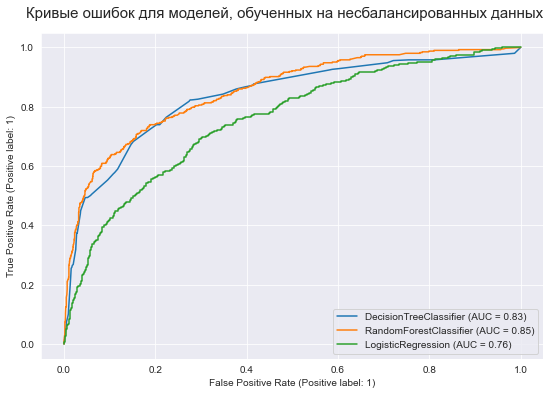

In [50]:
compare_roc_curves([tree_unbal_best, forest_unbal_best, logreg_unbal_best],
                   'Кривые ошибок для моделей, обученных на несбалансированных данных')

[К содержанию](#Содержание)

## 5. Борьба с дисбалансом<a name="5.-Борьба-с-дисбалансом"></a>

Для борьбы с дисбалансом протестируем три техники:
1. upsampling обучающей выборки,
2. уравновешивание классов,
3. изменение порога классификации.

### Upsampling<a name="Upsampling"></a>

Преобразуем обучающую выборку следующим образом:
1. разделим ее на отрицательные и положительные объекты;
2. скопируем 3 раза положительные объекты;
3. с учетом полученных данных создадим новую обучающую выборку;
4. перемешать данные.

После этого обучим все обучающие модели и посмотрим на их метрики. Для этого также создадим функцию, чтобы не писать одинаковые код несколько раз.

Начнем с апсэмплинга. Напишем для него функцию и посмотрим на баланс классов в новой выборке.

In [51]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=SEED)
    
    return X_upsampled, y_upsampled

In [52]:
X_train_upsamp, y_train_upsamp = upsample(X_train, y_train, 3)
check_split(X_train_upsamp, y_train_upsamp)

Размер выборки: 8446


,absolute,share_of_sample
0,4777,0.565593
1,3669,0.434407


Апсэмплинг проведен, теперь посмотрим как изменились метрики моделей.

#### Подготовка данных для GridSearch

Для GridSearch тренировочный и валидационный датасеты должны быть объединены в один.

In [53]:
X_gs_upsamp = np.concatenate((X_train_upsamp, X_val), axis=0)
y_gs_upsamp = np.concatenate((y_train_upsamp, y_val), axis=0)

Укажем для GridSearch индексы строк, на которых надо обучать и валидировать модели.

In [54]:
split_index_upsamp = [-1]*len(X_train_upsamp) + [0]*len(X_val)
pds_upsamp = PredefinedSplit(test_fold=split_index_upsamp)

#### Дерево решений

В этом пункте мы проходим пайплайн, подробно описанный [здесь](#Дерево-решений-дисбаланс). Мы опустили комментарии в этом шаге для экономии времени.

In [55]:
decision_tree = DecisionTreeClassifier(random_state=SEED)

tree_params = {'max_depth': range(1, 26)}

tree_gs_upsamp = GridSearchCV(
    estimator=decision_tree,
    param_grid=tree_params,
    scoring='f1',
    cv=pds_upsamp,
    refit=False)

tree_gs_upsamp.fit(X_gs_upsamp, y_gs_upsamp)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(1, 26)}, refit=False, scoring='f1')

In [56]:
tree_gs_upsamp.best_params_

{'max_depth': 7}

In [57]:
tree_upsamp_best = DecisionTreeClassifier(max_depth=7,
                                          random_state=SEED)

tree_upsamp_best.fit(X_train_upsamp, y_train_upsamp)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [58]:
get_metrics(tree_upsamp_best)

{'F1': 0.597, 'Recall': 0.671, 'Precision': 0.538, 'ROC AUC': 0.827}

In [59]:
research_result = research_result.append(
    make_new_row(model='Дерево решений',
                 method='Upsampling',
                 metrics=get_metrics(tree_upsamp_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
3,Дерево решений,Upsampling,0.597,0.671,0.538,0.827


#### Случайный лес

В этом пункте мы проходим пайплайн, подробно описанный [здесь](#Дерево-решений-дисбаланс). Мы опустили комментарии в этом шаге для экономии времени.

In [60]:
random_forest = RandomForestClassifier(random_state=SEED)

forest_params = {'n_estimators': range(10, 101, 10),
                 'max_depth': range(2, 31, 2)}

forest_gs_upsamp = GridSearchCV(
    estimator=random_forest,
    param_grid=forest_params,
    scoring='f1',
    cv=pds_upsamp,
    refit=False)

forest_gs_upsamp.fit(X_gs_upsamp, y_gs_upsamp)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': range(2, 31, 2),
                         'n_estimators': range(10, 101, 10)},
             refit=False, scoring='f1')

In [61]:
forest_gs_upsamp.best_params_

{'max_depth': 12, 'n_estimators': 80}

In [62]:
forest_upsamp_best = RandomForestClassifier(max_depth=12,
                                            n_estimators=80,
                                            random_state=SEED)

forest_upsamp_best.fit(X_train_upsamp, y_train_upsamp)

RandomForestClassifier(max_depth=12, n_estimators=80, random_state=42)

In [63]:
get_metrics(forest_upsamp_best)

{'F1': 0.645, 'Recall': 0.634, 'Precision': 0.656, 'ROC AUC': 0.857}

In [64]:
research_result = research_result.append(
    make_new_row(model='Случайный лес',
                 method='Upsampling',
                 metrics=get_metrics(forest_upsamp_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
4,Случайный лес,Upsampling,0.645,0.634,0.656,0.857


#### Логистическая регрессия

В этом пункте мы проходим пайплайн, подробно описанный [здесь](#Дерево-решений-дисбаланс). Мы опустили комментарии в этом шаге для экономии времени.

In [65]:
logreg = LogisticRegression(solver='liblinear',
                            random_state=SEED)

logreg_params = {'penalty': ['l2', 'l1']}

logreg_gs_upsamp = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_params,
    scoring='f1',
    cv=pds_upsamp,
    refit=False)

logreg_gs_upsamp.fit(X_gs_upsamp, y_gs_upsamp)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'penalty': ['l2', 'l1']}, refit=False, scoring='f1')

In [66]:
logreg_gs_upsamp.best_params_

{'penalty': 'l2'}

In [67]:
logreg_upsamp_best = LogisticRegression(penalty='l2',
                                        solver='liblinear',
                                        random_state=SEED)

logreg_upsamp_best.fit(X_train_upsamp, y_train_upsamp)

LogisticRegression(random_state=42, solver='liblinear')

In [68]:
get_metrics(logreg_upsamp_best)

{'F1': 0.481, 'Recall': 0.565, 'Precision': 0.419, 'ROC AUC': 0.76}

In [69]:
research_result = research_result.append(
    make_new_row(model='Логистическая регрессия',
                 method='Upsampling',
                 metrics=get_metrics(logreg_upsamp_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
5,Логистическая регрессия,Upsampling,0.481,0.565,0.419,0.76


#### Сравнение с моделями, обученными на несбалансированных данных

Посмотрим, как обучение моделей на данных с увеличенным размером первого класса сказалось на их качестве.

In [70]:
research_result

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
0,Дерево решений,Нет (данные несбалансированы),0.565,0.450,0.759,0.835
1,Случайный лес,Нет (данные несбалансированы),0.579,0.459,0.782,0.853
2,Логистическая регрессия,Нет (данные несбалансированы),0.316,0.216,0.587,0.756
3,Дерево решений,Upsampling,0.597,0.671,0.538,0.827
4,Случайный лес,Upsampling,0.645,0.634,0.656,0.857
5,Логистическая регрессия,Upsampling,0.481,0.565,0.419,0.760


По столбцу Recall видно, что все модели стали находить гораздо больше «уходящих» клиентов. Вместе с этим однако упал их precision: модели стали чаще записывать в отток клиентов, которые не собирались уходить. Больше всего precision упал у дерева решений, то есть оно сильнее всех переобучилось под уходящих клиентов.

По F1-мере наибольший прирост получила линейная регрессия. Видимо, из-за вырасшего в 2,5 recall'а. 

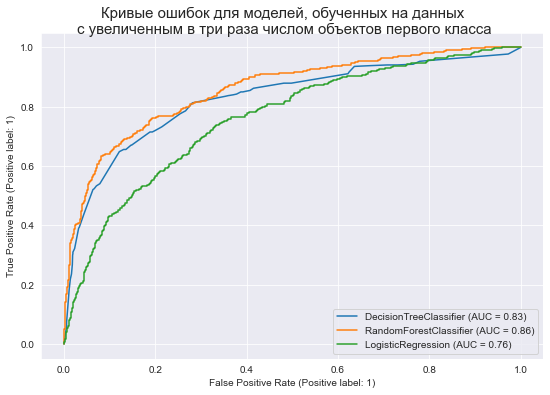

In [71]:
compare_roc_curves([tree_upsamp_best, forest_upsamp_best, logreg_upsamp_best],
                   'Кривые ошибок для моделей, обученных на данных \nc увеличенным в три раза числом объектов первого класса')

Графики ошибок и площади под ними почти не изменились.

[К содержанию](#Содержание)

### Уравновешивание классов<a name="Уравновешивание-классов"></a>

Для уравновешивания классов инициализации каждой модели укажем `class_weight='balanced'`. Модели сами посчитают, во сколько раз нулевой класс встречается чаще первого, и дадут ошибкам на меньшем классе больший вес.

#### Дерево решений

В этом пункте мы проходим пайплайн, подробно описанный [здесь](#Дерево-решений-дисбаланс). Мы опустили комментарии в этом шаге для экономии времени.

In [72]:
decision_tree = DecisionTreeClassifier(class_weight='balanced',
                                       random_state=SEED)

tree_params = {'max_depth': range(1, 26)}

tree_gs_bal = GridSearchCV(
    estimator=decision_tree,
    param_grid=tree_params,
    scoring='f1',
    cv=pds,
    refit=False)

tree_gs_bal.fit(X_gs, y_gs)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': range(1, 26)}, refit=False, scoring='f1')

In [73]:
tree_gs_bal.best_params_

{'max_depth': 6}

In [74]:
tree_bal_best = DecisionTreeClassifier(max_depth=6,
                                       class_weight='balanced',
                                       random_state=SEED)

tree_bal_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)

In [75]:
get_metrics(tree_bal_best)

{'F1': 0.59, 'Recall': 0.759, 'Precision': 0.482, 'ROC AUC': 0.831}

In [76]:
research_result = research_result.append(
    make_new_row(model='Дерево решений',
                 method='Уравновешивание классов',
                 metrics=get_metrics(tree_bal_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
6,Дерево решений,Уравновешивание классов,0.59,0.759,0.482,0.831


#### Случайный лес

В этом пункте мы проходим пайплайн, подробно описанный [здесь](#Дерево-решений-дисбаланс). Мы опустили комментарии в этом шаге для экономии времени.

In [77]:
random_forest = RandomForestClassifier(class_weight='balanced',
                                       random_state=SEED)

forest_params = {'n_estimators': range(10, 101, 10),
                 'max_depth': range(2, 31, 2)}

forest_gs_bal = GridSearchCV(
    estimator=random_forest,
    param_grid=forest_params,
    scoring='f1',
    cv=pds,
    refit=False)

forest_gs_bal.fit(X_gs, y_gs)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': range(2, 31, 2),
                         'n_estimators': range(10, 101, 10)},
             refit=False, scoring='f1')

In [78]:
forest_gs_bal.best_params_

{'max_depth': 10, 'n_estimators': 80}

In [79]:
forest_bal_best = RandomForestClassifier(max_depth=10,
                                         n_estimators=80,
                                         class_weight='balanced',
                                         random_state=SEED)

forest_bal_best.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=80,
                       random_state=42)

In [80]:
get_metrics(forest_bal_best)

{'F1': 0.635, 'Recall': 0.636, 'Precision': 0.633, 'ROC AUC': 0.858}

In [81]:
research_result = research_result.append(
    make_new_row(model='Случайный лес',
                 method='Уравновешивание классов',
                 metrics=get_metrics(forest_bal_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
7,Случайный лес,Уравновешивание классов,0.635,0.636,0.633,0.858


#### Логистическая регрессия

В этом пункте мы проходим пайплайн, подробно описанный [здесь](#Дерево-решений-дисбаланс). Мы опустили комментарии в этом шаге для экономии времени.

In [82]:
logreg = LogisticRegression(class_weight='balanced',
                            solver='liblinear',
                            random_state=SEED)

logreg_params = {'penalty': ['l2', 'l1']}

logreg_gs_bal = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_params,
    scoring='f1',
    cv=pds,
    refit=False)

logreg_gs_bal.fit(X_gs, y_gs)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42, solver='liblinear'),
             param_grid={'penalty': ['l2', 'l1']}, refit=False, scoring='f1')

In [83]:
logreg_gs_bal.best_params_

{'penalty': 'l2'}

In [84]:
logreg_bal_best = LogisticRegression(penalty='l2',
                                     class_weight='balanced',
                                     solver='liblinear',
                                     random_state=SEED)

logreg_bal_best.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [85]:
get_metrics(logreg_bal_best)

{'F1': 0.477, 'Recall': 0.661, 'Precision': 0.374, 'ROC AUC': 0.761}

In [86]:
research_result = research_result.append(
    make_new_row(model='Логистическая регрессия',
                 method='Уравновешивание классов',
                 metrics=get_metrics(logreg_bal_best)),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
8,Логистическая регрессия,Уравновешивание классов,0.477,0.661,0.374,0.761


#### Сравнение с моделями, обученными на несбалансированных данных

In [87]:
research_result.style.apply(highlight_exp, exp='Уравновешивание классов', axis=1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
0,Дерево решений,Нет (данные несбалансированы),0.565000,0.450000,0.759000,0.835000
1,Случайный лес,Нет (данные несбалансированы),0.579000,0.459000,0.782000,0.853000
2,Логистическая регрессия,Нет (данные несбалансированы),0.316000,0.216000,0.587000,0.756000
3,Дерево решений,Upsampling,0.597000,0.671000,0.538000,0.827000
4,Случайный лес,Upsampling,0.645000,0.634000,0.656000,0.857000
5,Логистическая регрессия,Upsampling,0.481000,0.565000,0.419000,0.760000
6,Дерево решений,Уравновешивание классов,0.590000,0.759000,0.482000,0.831000
7,Случайный лес,Уравновешивание классов,0.635000,0.636000,0.633000,0.858000
8,Логистическая регрессия,Уравновешивание классов,0.477000,0.661000,0.374000,0.761000


Уравновешивание классов так же, как и Upsampling, неплохо улучшило метрики моделей. Наибольший относительный прирост снова у логистической регрессии. По F1-мере опять лидируют случайный лес.

Интересно, что у дерева решений уравновешивание классов практически поменяло местами precision и recall. Дерево стало хорошо находить уходящих клиентов, но при этом увеличилось количество ложных срабатываний, когда клиент не собиравшийся уходить попал в отток.

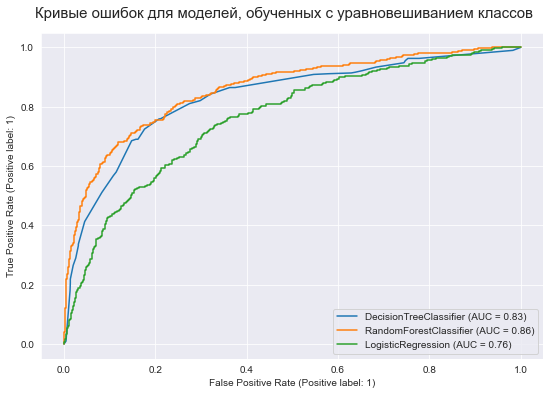

In [88]:
compare_roc_curves([tree_bal_best, forest_bal_best, logreg_bal_best],
                   'Кривые ошибок для моделей, обученных c уравновешиванием классов')

[К содержанию](#Содержание)

### Изменение порога классификации<a name="Изменение-порога-классификации"></a>

Модели умеют определять, насколько вероятен тот или иной класс, и на основе этой вероятности причислять объекты к ним. Когда класса всего два, появляется граница, где заканчивается первый класс и начинается второй. Она называется порогом. Изменяя порог, мы можем влиять на F1-меру.

Создадим функцию, которая будет принимать модель и данные для ее валидации, а возвращать таблицу с порогами, F1-мерами, полнотами и точностями. Для этого внутри функции объявим цикл, перебирающий попроги.

In [89]:
def threshold_table(model, suffix='', X=X_val, y=y_val):
    """
    Функция для расчета метрик качества бинарной классификации
    при разных порогах отнесения к первому классу.
    """
    probs = model.predict_proba(X)
    probs_one = probs[:, 1]
    result = pd.DataFrame(
        columns=['Порог', 'F1'+suffix, 'Recall'+suffix, 'Precision'+suffix])
    
    for threshold in np.arange(0, 1, 0.05):
        preds = probs_one > threshold
        
        f1 = round(f1_score(y_val, preds), 3)
        recall = round(recall_score(y_val, preds), 3)
        precision = round(precision_score(y_val, preds), 3)
        
        row = pd.DataFrame(
            columns = ['Порог', 'F1'+suffix, 'Recall'+suffix, 'Precision'+suffix],
            data = [[threshold, f1, recall, precision]])
        
        result = result.append(row, ignore_index=True)
    
    return result

#### Дерево решений

В этом разделе мы не будем переобучать модели, а построим таблицы с метриками классификации для разных порогов.

В таблицу с результатами эксперимента запишем лучшую F1-меру и соответствующие ей остальные метрики.

In [90]:
tree_thresholds = threshold_table(tree_unbal_best, '_Tree')
tree_thresholds.sort_values('F1_Tree', ascending=False).head()

,Порог,F1_Tree,Recall_Tree,Precision_Tree
5,0.25,0.599,0.673,0.539
9,0.45,0.589,0.494,0.731
8,0.40,0.589,0.494,0.731
4,0.20,0.578,0.740,0.474
6,0.30,0.576,0.590,0.562


In [91]:
research_result = research_result.append(
    make_new_row(model='Дерево решений',
                 method='Измениние порога классификации',
                 metrics={
                     'F1': 0.599,
                     'Recall': 0.673,
                     'Precision': 0.539,
                     'ROC AUC': np.nan}),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
9,Дерево решений,Измениние порога классификации,0.599,0.673,0.539,NaN


#### Случайный лес

In [92]:
forest_thresholds = threshold_table(forest_unbal_best, '_Forest')
forest_thresholds.sort_values('F1_Forest', ascending=False).head()

,Порог,F1_Forest,Recall_Forest,Precision_Forest
8,0.40,0.630,0.575,0.696
7,0.35,0.620,0.614,0.625
6,0.30,0.610,0.668,0.561
9,0.45,0.608,0.516,0.739
5,0.25,0.596,0.720,0.508


In [93]:
research_result = research_result.append(
    make_new_row(model='Случайный лес',
                 method='Измениние порога классификации',
                 metrics={
                     'F1': 0.630,
                     'Recall': 0.575,
                     'Precision': 0.696,
                     'ROC AUC': np.nan}),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
10,Случайный лес,Измениние порога классификации,0.63,0.575,0.696,NaN


#### Логистическая регрессия

In [94]:
logreg_thresholds = threshold_table(logreg_unbal_best, '_LogReg')
logreg_thresholds.sort_values('F1_LogReg', ascending=False).head()

/Users/alexandersaushev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Порог,F1_LogReg,Recall_LogReg,Precision_LogReg
4,0.20,0.484,0.690,0.372
5,0.25,0.480,0.570,0.414
6,0.30,0.475,0.477,0.473
7,0.35,0.467,0.425,0.518
3,0.15,0.446,0.776,0.313


In [95]:
research_result = research_result.append(
    make_new_row(model='Логистическая регрессия',
                 method='Измениние порога классификации',
                 metrics={
                     'F1': 0.484,
                     'Recall': 0.690,
                     'Precision': 0.372,
                     'ROC AUC': np.nan}),
    ignore_index=True)

research_result.tail(1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
11,Логистическая регрессия,Измениние порога классификации,0.484,0.69,0.372,NaN


#### Сравнение моделей с разными порогами

Объединим таблицы порогов для разных моделей в одну и выделим для каждой лучшую F1-меру.

In [96]:
res_thresholds = tree_thresholds.merge(forest_thresholds,
                      on='Порог')

res_thresholds = res_thresholds.merge(logreg_thresholds,
                      on='Порог')

res_thresholds.style.highlight_max(subset=['F1_Tree', 'F1_Forest', 'F1_LogReg'],
                                   color='yellow', axis = 0)

,Порог,F1_Tree,Recall_Tree,Precision_Tree,F1_Forest,Recall_Forest,Precision_Forest,F1_LogReg,Recall_LogReg,Precision_LogReg
0,0.000000,0.336000,0.980000,0.202000,0.345000,0.998000,0.208000,0.338000,1.000000,0.204000
1,0.050000,0.402000,0.948000,0.255000,0.426000,0.975000,0.272000,0.360000,0.973000,0.221000
2,0.100000,0.555000,0.826000,0.418000,0.489000,0.902000,0.335000,0.412000,0.894000,0.268000
3,0.150000,0.567000,0.823000,0.432000,0.525000,0.826000,0.384000,0.446000,0.776000,0.313000
4,0.200000,0.578000,0.740000,0.474000,0.563000,0.771000,0.443000,0.484000,0.690000,0.372000
5,0.250000,0.599000,0.673000,0.539000,0.596000,0.720000,0.508000,0.480000,0.570000,0.414000
6,0.300000,0.576000,0.590000,0.562000,0.610000,0.668000,0.561000,0.475000,0.477000,0.473000
7,0.350000,0.575000,0.575000,0.575000,0.620000,0.614000,0.625000,0.467000,0.425000,0.518000
8,0.400000,0.589000,0.494000,0.731000,0.630000,0.575000,0.696000,0.429000,0.351000,0.550000
9,0.450000,0.589000,0.494000,0.731000,0.608000,0.516000,0.739000,0.374000,0.278000,0.574000


Дерево решений и логистическая регрессия показывают лучшие результаты по F1-мере при маленьких порогах. Это значит, что даже если модели слабо уверены в том, что клиент уйдет, они все равно записывают его в отток. Из-за этого случается много ложных срабатываний, о чем говорят низкие precision'ы, особенно у логистической регрессии.

#### Сравнение с моделями, обученными на несбалансированных данных без изменения порога

In [97]:
research_result.style.apply(highlight_exp, exp='Измениние порога классификации', axis=1)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
0,Дерево решений,Нет (данные несбалансированы),0.565000,0.450000,0.759000,0.835000
1,Случайный лес,Нет (данные несбалансированы),0.579000,0.459000,0.782000,0.853000
2,Логистическая регрессия,Нет (данные несбалансированы),0.316000,0.216000,0.587000,0.756000
3,Дерево решений,Upsampling,0.597000,0.671000,0.538000,0.827000
4,Случайный лес,Upsampling,0.645000,0.634000,0.656000,0.857000
5,Логистическая регрессия,Upsampling,0.481000,0.565000,0.419000,0.760000
6,Дерево решений,Уравновешивание классов,0.590000,0.759000,0.482000,0.831000
7,Случайный лес,Уравновешивание классов,0.635000,0.636000,0.633000,0.858000
8,Логистическая регрессия,Уравновешивание классов,0.477000,0.661000,0.374000,0.761000
9,Дерево решений,Измениние порога классификации,0.599000,0.673000,0.539000,nan


Больше всего от подбора порога выигрыла логистическая регрессия: F1-мера увеличилась с 0,32 до 0,48. У нее в три раза вырос recall, но просел precision. То есть с новым порогом классификации модель стала не только чаще находить действительно уходящих клиентов, но и неправильно отправлять в отток клиентов, которые не собирались уходить.

Аналогичные картины у дерева решений и случайного леса, только в меньшем масштабе. Этим моделям изменение порога классификации дало меньшее увеличение F1-метрики. Recall и precision также изменились меньше.

[К содержанию](#Содержание)

### Сравнение способов борьбы с дисбалансом<a name="Сравнение-способов-борьбы-с-дисбалансом"></a>

Мы попробовали три способа борьбы с дисбалансом: upsampling, уравновешивание классов и изменение порога классификации. Посмотрим на таблицу с результатами исследования.

In [98]:
research_result.style.highlight_max(subset=['F1'], color='lightgreen', axis=0)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
0,Дерево решений,Нет (данные несбалансированы),0.565000,0.450000,0.759000,0.835000
1,Случайный лес,Нет (данные несбалансированы),0.579000,0.459000,0.782000,0.853000
2,Логистическая регрессия,Нет (данные несбалансированы),0.316000,0.216000,0.587000,0.756000
3,Дерево решений,Upsampling,0.597000,0.671000,0.538000,0.827000
4,Случайный лес,Upsampling,0.645000,0.634000,0.656000,0.857000
5,Логистическая регрессия,Upsampling,0.481000,0.565000,0.419000,0.760000
6,Дерево решений,Уравновешивание классов,0.590000,0.759000,0.482000,0.831000
7,Случайный лес,Уравновешивание классов,0.635000,0.636000,0.633000,0.858000
8,Логистическая регрессия,Уравновешивание классов,0.477000,0.661000,0.374000,0.761000
9,Дерево решений,Измениние порога классификации,0.599000,0.673000,0.539000,nan


Лучше всех себя показал upsampling: дерево решений и случайный лес получили с ним максимальные F1-меры, логистическая регрессия — почти максимальную.

Также upsampling дал наиболее сбалансированную пару recall и precision для всех моделей. Модели, обученные на данных с другой обработкой дисбаланса, чаще начинали слишком активно записывать клиентов в отток, повышая recall и жертвуя precision. Особенно это заметно на дереве решений и логистической регрессии.

Еще мы заметили, что наибольший прирост качества от борьбы с дисбалансом получает логистическая регрессия. Скорее всего, это связано с тем, что изначально у нее были самые низкие метрики, сильно отстающие от других моделей. Борьба с дисбалансом сократила это расстояние.

Однако если мы отсортируем результаты экспериментов по убыванию F1-меры, то увидим, что бОльшую роль все-таки играет архитектура модели, а не исправление дисбаланса.

Так, первые три места занимает случайный лес с разными обработками дисбаланса. Вторая тройка мест — за деревом решений. Логистическая регрессия проигрывает лесу и дереву, даже когда обучалась с учетом дисбаланса классов.

In [99]:
research_result.sort_values('F1', ascending=False)

,Модель,Способ борьбы с дисбалансом,F1,Recall,Precision,ROC AUC
4,Случайный лес,Upsampling,0.645,0.634,0.656,0.857
7,Случайный лес,Уравновешивание классов,0.635,0.636,0.633,0.858
10,Случайный лес,Измениние порога классификации,0.630,0.575,0.696,NaN
9,Дерево решений,Измениние порога классификации,0.599,0.673,0.539,NaN
3,Дерево решений,Upsampling,0.597,0.671,0.538,0.827
6,Дерево решений,Уравновешивание классов,0.590,0.759,0.482,0.831
1,Случайный лес,Нет (данные несбалансированы),0.579,0.459,0.782,0.853
0,Дерево решений,Нет (данные несбалансированы),0.565,0.450,0.759,0.835
11,Логистическая регрессия,Измениние порога классификации,0.484,0.690,0.372,NaN
5,Логистическая регрессия,Upsampling,0.481,0.565,0.419,0.760


## 6. Тестирование лучшей модели<a name="6.-Тестирование-лучшей-модели"></a>

В ходе исследования мы выяснили, что лучшая F1-мера у случайного леса, обученного на данных с искусственно увеличенным числом уходящих клиентов. Его и будем использовать для финального тестирования.

Для улучшения качества предсказаний на тестовой выборке переобучим модель на сумме тренировочной и валидационной (во время исследования модель обучалась только на трейне).

In [100]:
forest_upsamp_best.fit(X_gs_upsamp, y_gs_upsamp)

RandomForestClassifier(max_depth=12, n_estimators=80, random_state=42)

Получим метрики качества предсказаний на тестовой выборке.

In [101]:
get_metrics(forest_upsamp_best, X_test, y_test)

{'F1': 0.621, 'Recall': 0.577, 'Precision': 0.671, 'ROC AUC': 0.86}

F1-мера оказалась ниже, чем на валидационной выборке, но необходимый порог в 0,59 мы прошли.

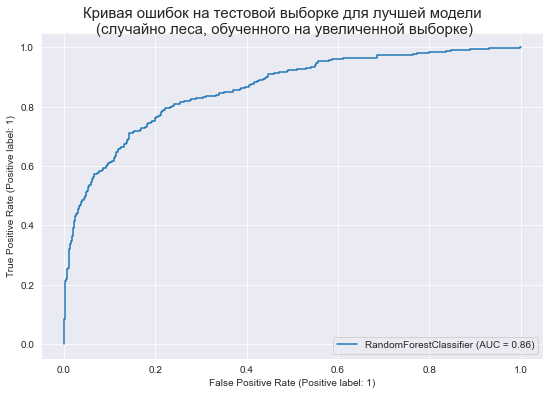

In [102]:
compare_roc_curves([forest_upsamp_best], X=X_test, y=y_test,
                   title='Кривая ошибок на тестовой выборке для лучшей модели \n(случайно леса, обученного на увеличенной выборке)')

Также выведем важность признаков для итоговой модели.

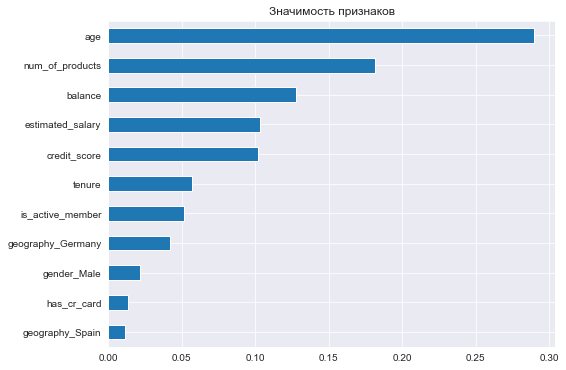

In [103]:
plot_feature_importances_graph(forest_upsamp_best)

[К содержанию](#Содержание)